#### Imports

In [1]:
import torch
import classiq

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torchvision.transforms as transforms

from typing import Dict
from classiq import create_model, synthesize, show, QFunc, QArray, QBit, Output, allocate, RX, RY, RZ, RZZ, RXX, RYY, CZ
from classiq.builtin_functions import HardwareEfficientAnsatz
from classiq.applications.qnn import QLayer
from classiq.execution import execute_qnn
from classiq.synthesis import SerializedQuantumProgram

from classiq.applications.qnn.types import (
    MultipleArguments,
    SavedResult,
    ResultsCollection,
)

classiq.authenticate()

C:\Users\asifs\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\classiq\_internals\authentication\token_manager.py:82: UserWarning: Device is already registered.
Generating a new refresh token should only be done if the current refresh token is compromised.
To do so, set the overwrite parameter to true
  warnings.warn(


#### Classical Layer for Image Commpression:
The input MNIST images are all 28 × 28. This Classical Layer will firstly center-crop them to 24 × 24 and
then down-sample them to 4 × 4 for MNIST.

In [2]:
def classical_compression(x):
    """
    The input MNIST images are all 28 × 28. This function will firstly center-crop 
    them to 24 × 24 and then down-sample them to 4 × 4 for MNIST.
    """
    transform = transforms.CenterCrop(24) 
    image_crop = transform(x)
    image_crop_reshaped = image_crop.view(1, -1, 24, 24)
    transform = transforms.Resize(size = (4,4))
    resize_image = transform(image_crop_reshaped)
    resize_image_squeezed = resize_image.squeeze()
    res = torch.flatten(resize_image_squeezed)
    
    return res


In [3]:
@QFunc
def encoding(q: QArray[QBit]) -> None:
    """
    This function encodes the input data into the qubits. This input data is a 4x4 image pixel values 
    converted into angle for rotation gates (RX, RY, RZ, RX) in form of a 16x1 vector. 
    We encode 4 pixels per qubit.

    Args:
        q (QArray[QBit]): Array of four Qubits to encode the input data into.
    """
    RX(theta="input_0", target=q[0]) # Pixel 0 on Qubit 0
    RY(theta="input_1", target=q[0]) # Pixel 1 on Qubit 0
    RZ(theta="input_2", target=q[0]) # Pixel 2 on Qubit 0
    RX(theta="input_3", target=q[0]) # Pixel 3 on Qubit 0
    
    RX(theta="input_4", target=q[1]) # Pixel 4 on Qubit 1
    RY(theta="input_5", target=q[1]) # Pixel 5 on Qubit 1
    RZ(theta="input_6", target=q[1]) # Pixel 6 on Qubit 1
    RX(theta="input_7", target=q[1]) # Pixel 7 on Qubit 1
    
    RX(theta="input_8", target=q[2]) # Pixel 8 on Qubit 2
    RY(theta="input_9", target=q[2]) # Pixel 9 on Qubit 2
    RZ(theta="input_10", target=q[2]) # Pixel 10 on Qubit 2
    RX(theta="input_11", target=q[2]) # Pixel 11 on Qubit 2
    
    RX(theta="input_12", target=q[3]) # Pixel 12 on Qubit 3
    RY(theta="input_13", target=q[3]) # Pixel 13 on Qubit 3
    RZ(theta="input_14", target=q[3]) # Pixel 14 on Qubit 3
    RX(theta="input_15", target=q[3]) # Pixel 15 on Qubit 3


In [4]:
@QFunc
def mixing(q: QArray[QBit]) -> None:
    """
    This function performs the mixing operation on the qubits. 
    This is done by applying a series of RZZ, RXX, RYY gates to form a
    ring connection.

    Args:
        q (QArray[QBit]): Array of four Qubits to apply the mixing operation on.
    """
    RZZ(theta="weight_0", target=q[0:2])
    RZZ(theta="weight_1", target=q[1:3])
    RZZ(theta="weight_2", target=q[2:4])
    # RZZ(theta="weight_3", target=q[0:3])
    
    RXX(theta="weight_4", target=q[0:2])
    RXX(theta="weight_5", target=q[1:3])
    RXX(theta="weight_6", target=q[2:4])
    # RXX(theta="weight_7", target=q[3:1])
    
    RYY(theta="weight_8", target=q[0:2])
    RYY(theta="weight_9", target=q[1:3])
    RYY(theta="weight_10", target=q[2:4])
    # RYY(theta="weight_11", target=q[3:1])

In [5]:
@QFunc
def cz_block(q: QArray[QBit]) -> None:
    """
    This function performs the entanglement operation on the qubits by applying
    CZ gates between each qubit.

    Args:
        q (QArray[QBit]): Array of four Qubits to apply the entanglement operation on.
    """
    CZ(control=q[0], target=q[1])
    CZ(control=q[1], target=q[2])
    CZ(control=q[2], target=q[3])

In [6]:
@QFunc
def main(res: Output[QArray[QBit]]) -> None:
    """
    This is the main function from which model will be created. 
    It calls the other functions to perform the encoding, mixing and entanglement.

    Args:
        res (Output[QArray[QBit]]): Output QArray of QBits from which the model will be created.
    """
    allocate(4, res)
    encoding(q=res)
    mixing(q=res)
    cz_block(q=res)

In [7]:
# Create a model
model = create_model(main)
quantum_program = synthesize(model)
# show(quantum_program)

Opening: https://platform.classiq.io/circuit/63fae884-506e-4554-bd2b-34cfdeb20777?version=0.33.0


In [8]:
def execute(quantum_program: SerializedQuantumProgram, arguments: MultipleArguments) -> ResultsCollection:
    return execute_qnn(quantum_program, arguments)

##### Experimenting from here

In [9]:
def post_process(result: SavedResult) -> torch.Tensor:
    counts: dict = result.value.counts
    # The probability of measuring |0>
    print(f"counts: {counts}")
    p_zero: float = counts.get("0", 0.0) / sum(counts.values())
    return torch.tensor(p_zero)

In [10]:
class Net(torch.nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__()
        self.qlayer = QLayer(
            quantum_program,
            execute,
            post_process,
            *args,
            **kwargs
        )
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.qlayer(x)
        return x

In [11]:
qnn = Net()

### Data Loading

In [12]:
# class CTDataset(Dataset):
#     def __init__(self, filepath):
#         self.x, self.y = torch.load(filepath)
#         self.x = self.x / 255.
#         self.y = F.one_hot(self.y, num_classes=10).to(float)
#     def __len__(self): 
#         return self.x.shape[0]
#     def __getitem__(self, ix): 
#         return self.x[ix], self.y[ix]

In [13]:
import torch.nn as nn
import torch.optim as optim

In [14]:
_LEARNING_RATE = 1.0
# load dataset
# train_ds = CTDataset('MNIST_DATASET/processed/training.pt')
# test_ds = CTDataset('MNIST_DATASET/processed/test.pt')
# train_dl = DataLoader(train_ds, batch_size=5)

# choosing our loss function
loss_func = nn.L1Loss()

# choosing our optimizer
optimizer = optim.SGD(qnn.parameters(), lr=_LEARNING_RATE)

In [15]:
x, y = torch.load('MNIST_DATASET/processed/training.pt')

In [16]:
train_image = x[1]
train_label = y[1]

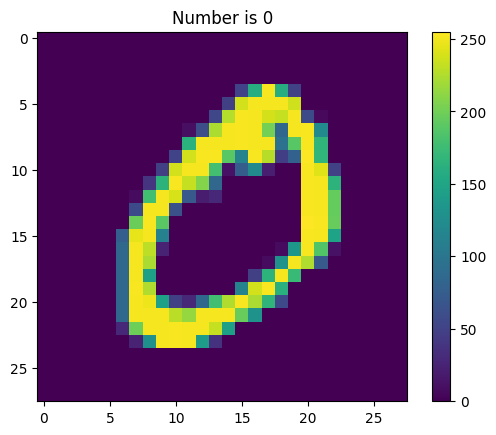

In [17]:
import matplotlib.pyplot as plt
plt.imshow(train_image.numpy())
plt.title(f'Number is {train_label.numpy()}')
plt.colorbar()
plt.show()

In [18]:
ct_image = classical_compression(train_image)

C:\Users\asifs\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [19]:
print(ct_image)

tensor([  0,   0, 229,   0,   0, 244,  36,  54,   0,   0,   2,   3,   0, 252,
          0,   0], dtype=torch.uint8)


In [30]:
label=train_label
def train(
    model: nn.Module,
    data_loader: torch.Tensor,
    loss_func: nn.modules.loss._Loss,
    optimizer: optim.Optimizer,
    epoch: int = 20,
) -> None:
    for index in range(epoch):
        for data in data_loader:
            optimizer.zero_grad()
            print(data)
            output = model(data)
            loss = loss_func(output, label)
            loss.backward()
            optimizer.step()


train(qnn, ct_image, loss_func, optimizer)

tensor(0, dtype=torch.uint8)


ValueError: not enough values to unpack (expected 2, got 0)